# Parte 2 - Classificação de Algarismos

Nesta parte, comparamos o desempenho de diferentes algoritmos de classificação supervisionada na tarefa de identificar algarismos a partir de imagens 8x8. Para isso usamos as imagens disponíveis no Pen-Based
Recognition of Handwritten Digits Data Set e acessíveis pelo sklearn através da função load_digits. Os dados estão disponíveis em forma de imagem em digits.image ou em forma de vetor em digits.data e a classe de cada dado pode ser encontrada em digits.target.

Abaixo, demonstramos os 10 primeiros algarismos do conjunto de dados em forma de imagem:

0


<Figure size 432x288 with 0 Axes>

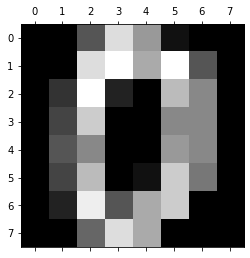

1


<Figure size 432x288 with 0 Axes>

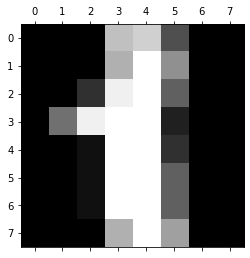

2


<Figure size 432x288 with 0 Axes>

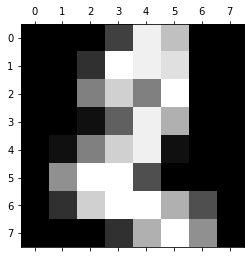

3


<Figure size 432x288 with 0 Axes>

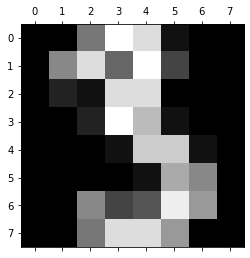

4


<Figure size 432x288 with 0 Axes>

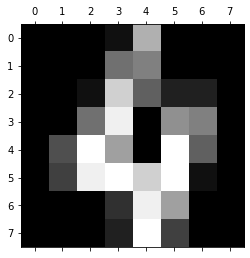

5


<Figure size 432x288 with 0 Axes>

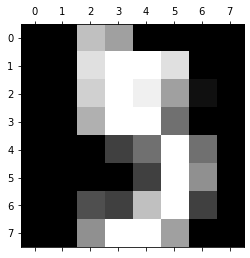

6


<Figure size 432x288 with 0 Axes>

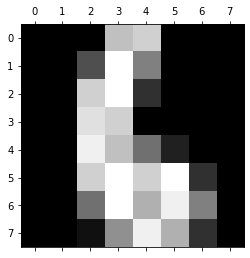

7


<Figure size 432x288 with 0 Axes>

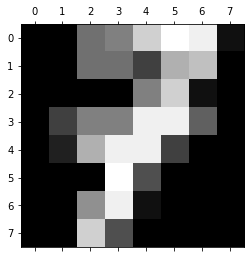

8


<Figure size 432x288 with 0 Axes>

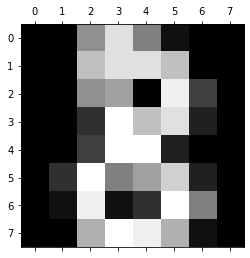

9


<Figure size 432x288 with 0 Axes>

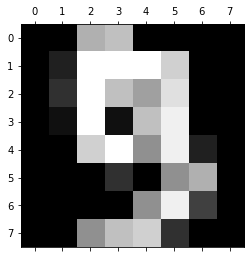

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()
for i in range(10):
    print(digits.target[i])
    plt.gray() 
    plt.matshow(digits.images[i]) 
    plt.show() 

Em seguida, separamos os dados em conjuntos de treinamento (90%) e de teste (10%):

In [2]:
from sklearn.model_selection import train_test_split

digits_data_train, digits_data_test, digits_target_train, digits_target_test = \
        train_test_split(digits.data, digits.target, test_size=0.1, random_state=42)

print("Dados para treino: %d" % digits_data_train.shape[0])
print("Dados para teste: %d" % digits_data_test.shape[0])

Dados para treino: 1617
Dados para teste: 180


Como cada dado possui 64 *features*, fizemos a estandardização dos dados e usamos o algoritmo LDA para diminuir sua dimensão de forma a aumentar sua densidade. Dessa forma, facilitando o treinamento de algoritmos de classificação.

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
reduced_digits_data_train = lda.fit_transform(digits_data_train, digits_target_train)
print("A dimensionalidade dos dados foi reduzida de %d para %d." \
      % (digits.data.shape[1], reduced_digits_data_train.shape[1]))

A dimensionalidade dos dados foi reduzida de 64 para 9.


Para visualizar os dados, utilizamos o algoritmo t-SNE. O algoritmo t-SNE foi criado com o propósito de reduzir a dimensionalidade de um conjunto de dados para sua visualização.

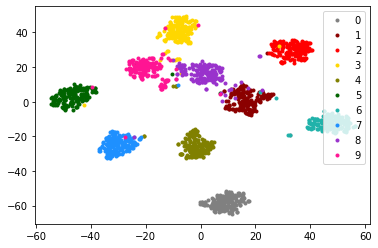

In [4]:
from sklearn.manifold import TSNE
import numpy as np

viz_digits_data_train = TSNE(n_components=2, random_state=42).fit_transform(reduced_digits_data_train)

colors = ['gray', 'darkred', 'red', 'gold', 'olive', 'darkgreen', 'lightseagreen', 'dodgerblue', 'darkorchid', 'deeppink']
for i in range(10):
    indices = np.where(digits_target_train == i)
    selected_data = np.take(viz_digits_data_train, indices, 0)
    plt.plot(selected_data[0,:,0], selected_data[0,:,1], '.', color=colors[i], label=i)
plt.legend()
plt.show()